### plot 19V vs. 37V brightness temperatures, for seaice and open water (masking land ice)

Try to reproduce Figure 2a of the
[AMSR-E seaice paper](http://ezproxy.library.ubc.ca/login?url=http://ieeexplore.ieee.org/document/1196042)


In [1]:
%matplotlib inline
import glob
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from rasterio.transform import from_bounds
from pyresample import kd_tree,image, geometry
from e582lib.map_slices import make_xy
import pyproj
from pathlib import Path
import matplotlib
import warnings

In [2]:
#
# we are in the notebooks folder
#
dirpath=Path('.')
#
# jump up one directory and look in the seaice_data folder
# to find all files starting with EASE
#
ease_files=dirpath.glob('../seaice_data/EASE*')
data_dict={}
for a_file in ease_files:
    #
    # in python 3.5, need to convert the Path object
    # in python 3.6, don't need to do this since open can
    # handle Path objects
    #
    with open(str(a_file),'rb') as infile:
        filestring=str(a_file)
        #
        # we don't want the high reolution or time data files
        #
        if filestring.find('NH') > -1:
            continue
        if filestring.find('TIM') > -1:
            continue
        #
        # separate out the filename to use as
        # a dictionary key
        #
        key=a_file.parts[-1]
        print('key is: {}'.format(key))
        the_bytes=infile.read()
        the_string=bytearray(the_bytes)
        the_array=np.frombuffer(the_string,dtype=np.uint16)
        the_array.shape=[721,721]
        the_array=the_array.astype(np.float32)
        the_array=the_array/10.
        data_dict[key]=the_array

key is: EASE-F17-NL2014032A-V2.19H
key is: EASE-F17-NL2014032A-V2.19V
key is: EASE-F17-NL2014032A-V2.22V
key is: EASE-F17-NL2014032A-V2.37H
key is: EASE-F17-NL2014032A-V2.37V
key is: EASE-F17-NL2014032A-V2.91H
key is: EASE-F17-NL2014032A-V2.91V
key is: EASE-F17-NL2014032D-V2.19H
key is: EASE-F17-NL2014032D-V2.19V
key is: EASE-F17-NL2014032D-V2.22V
key is: EASE-F17-NL2014032D-V2.37H
key is: EASE-F17-NL2014032D-V2.37V
key is: EASE-F17-NL2014032D-V2.91H
key is: EASE-F17-NL2014032D-V2.91V


### Mask the missing data (0 values)

In [3]:
files=['EASE-F17-NL2014032A-V2.37V',
       'EASE-F17-NL2014032A-V2.19V']
#
# get the first filename
#
for file_name in files:
    temps=data_dict[file_name]
    data_dict[file_name]=np.ma.masked_where(temps < 50.,temps)

### now resample

Take the projection code from seaice.ipynb and turn it into a function

In [4]:
def do_project(orig_image):
    """
    project a standard Northern hemisphere EASE-grid brightness temperature map onto 
    North American laea projection:
    
    Parameters
    ----------
    
    orig_image: masked array (721x721)
       masked array of float32 values from NSIDC brightness temperature file
       
    
    Returns
    -------
    
    result: masked array (360x360)
       pyresampled array with extent set to north of 50 degrees, centered on 
       -90 deg longitude
       
    basemap_args: dict
       dictionary to construct a Basemap in the new projection
       
    new_extent: list
        corner x,y values [llx,lly,urx,ury] in new projection
    
    """
    ncols,nrows=orig_image.shape
    if (nrows != 721) or (ncols != 721):
        raise ValueError('expecting 721x721, got {}'.format(orig_image.shape))
    #http://nsidc.org/data/gis/headers/NL.hdr
    cornerx=9024309  #meters, from NL.hdr
    cornery=cornerx
    newcornerx=cornerx/2.
    newcornery=newcornerx
    new_extent=[-newcornerx,-newcornery,newcornerx,newcornery]
    orig_crs=dict(init='epsg:3408')
    orig_extent=[-cornerx,-cornery,cornerx,cornery]
    newrows=360
    newcols=newrows
    radius=6371228
    new_crs=dict(proj='laea',lat_0=90,lon_0= -90,a=radius,b=radius,units='m')
    new_basemap_args=dict(projection='laea',lat_0=90,lon_0= -90,rsphere=(radius,radius))
    from_def = geometry.AreaDefinition('orig', 'orig image', 'area_orig',
                                   orig_crs,
                                   ncols, nrows,
                                   orig_extent)
    to_def = geometry.AreaDefinition('new', 'new image','area_new',
                                   new_crs,
                                   newcols,newrows,
                                   new_extent)

    from_nn = image.ImageContainerNearest(orig_image,from_def, 
                                          radius_of_influence=18000,fill_value=None)
    to_nn = from_nn.resample(to_def)
    result = to_nn.image_data
    return result,new_basemap_args,new_extent


### Apply the do_project function to the two brightness temperature arrays

In [5]:
mapped_dict={}
for filename in files:
    masked_temps=data_dict[filename]
    new_temps,new_basemap_args,new_extent=do_project(masked_temps)
    mapped_dict[filename]=new_temps
    

### set up the new array height and width for basemap plotting

In [6]:
newcols,newrows=new_temps.shape
llx,lly,urx,ury=new_extent
width=urx - llx
height=width

### Plot the 37V reprojection

In [7]:
#
# use the same colorbar for each image
#
cmap=matplotlib.cm.get_cmap('viridis')
vmin=220
vmax=260
the_norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)

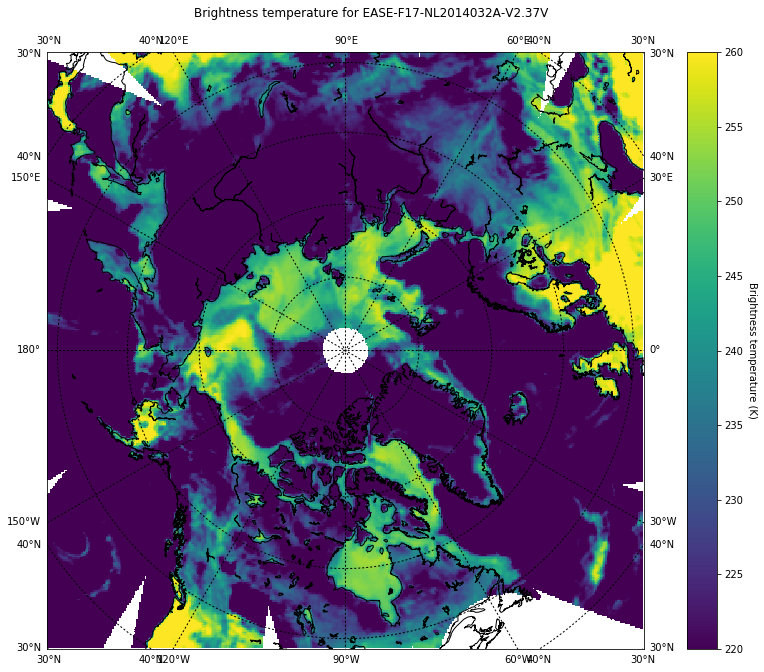

In [8]:
file_name='EASE-F17-NL2014032A-V2.37V'
temps37V=mapped_dict[file_name]
fig,ax=plt.subplots(1,1,figsize=(12,12))
basemap_args=dict(new_basemap_args)
basemap_args.update(dict(ax=ax,resolution='l',width=width,height=height))
bmap=Basemap(**basemap_args)
#bmap.imshow(result_data_nn,origin='upper')
new_transform = from_bounds(bmap.llcrnrx,bmap.llcrnry,
                             bmap.urcrnrx,bmap.urcrnry,newcols,newrows)
xvals,yvals=make_xy(0,newrows,0,newcols,new_transform)
CS=bmap.pcolormesh(xvals,yvals,temps37V,norm=the_norm,cmap=cmap)
cax=bmap.colorbar(CS,'right',pad=0.6)
out=cax.ax.set_ylabel('Brightness temperature (K)')
out.set_rotation(270)
out.set_verticalalignment('bottom')
lat_sep,lon_sep= 10,30
parallels = np.arange(30, 90, lat_sep)
meridians = np.arange(-180, 180, lon_sep)
bmap.drawparallels(parallels, labels=[1, 1, 1, 1],
                       fontsize=10, latmax=70)
bmap.drawmeridians(meridians, labels=[1, 1, 1, 1],
                       fontsize=10, latmax=90);
bmap.drawcoastlines()
fig.suptitle('Brightness temperature for {}'.format(file_name),y=0.9);

### Repeat for 19V

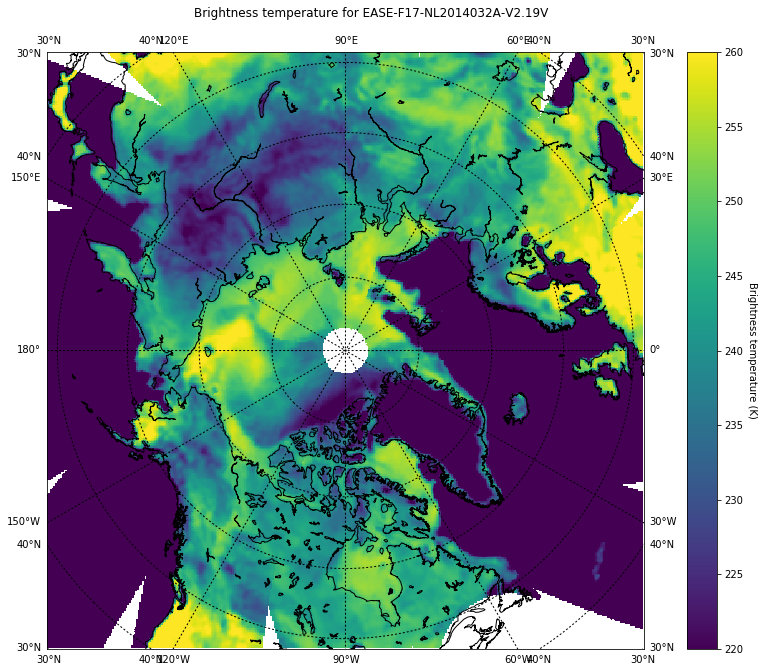

In [12]:
file_name='EASE-F17-NL2014032A-V2.19V'
temps19V=mapped_dict[file_name]
fig,ax=plt.subplots(1,1,figsize=(12,12))
basemap_args.update(dict(ax=ax))
bmap=Basemap(**basemap_args)
#bmap.imshow(result_data_nn,origin='upper')
xvals,yvals=make_xy(0,newrows,0,newcols,new_transform)
CS=bmap.pcolormesh(xvals,yvals,temps19V,norm=the_norm,cmap=cmap)
cax=bmap.colorbar(CS,'right',pad=0.6)
out=cax.ax.set_ylabel('Brightness temperature (K)')
out.set_rotation(270)
out.set_verticalalignment('bottom')
bmap.drawparallels(parallels, labels=[1, 1, 1, 1],
                       fontsize=10, latmax=70)
bmap.drawmeridians(meridians, labels=[1, 1, 1, 1],
                       fontsize=10, latmax=90);
bmap.drawcoastlines()
fig.suptitle('Brightness temperature for {}'.format(file_name),y=0.9);
np.savez('save19',temps19V=np.ma.filled(temps19V,np.nan))

### filter out latitudes south of 60 deg N latitude

In [ ]:
lons,lats = bmap(xvals,yvals,inverse=True)
south = lats < 60
temps37V_sea=np.array(temps37V,copy=True)
temps19V_sea=np.array(temps19V,copy=True)
temps37V_sea[south]=np.nan
temps19V_sea[south]=np.nan
fig,ax=plt.subplots(1,2,figsize=(14,8))
ax[0].imshow(temps37V_sea,origin='upper',norm=the_norm,cmap=cmap)
ax[1].imshow(temps19V_sea,origin='upper',norm=the_norm,cmap=cmap);

### now get rid of the land using the [EASE-grid land mask](http://nsidc.org/data/docs/daac/nsidc0607-ease-mask/)

Use the PIL library introduced in the color_palettes.ipynb notebook from week 3 to read the ocena mask (blue=255) from the RGB png file.


In [ ]:
from PIL import Image
land_mask_file=next(dirpath.glob('../seaice_data/Nl.*.721x721.png'))
img = Image.open(land_mask_file)
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(img,origin='upper');

Use [pdir2](https://github.com/laike9m/pdir2) to get information about the image object

In [ ]:
import pdir
print(pdir(img))

### turn the img into a numpy array

In [ ]:
mask=np.array(img)
print(mask.shape)

### Grab the blue layer (last index 2) and set all ocean pixels to 1 and all land pixels to 0

In [ ]:
mask=np.array(img)
fig,ax=plt.subplots(1,1,figsize=(10,10))
hit=mask[:,:,2] < 200
ocean=mask[:,:,2]
ocean=ocean.astype(np.float32)
ocean[hit]=0
ocean[~hit]=1
ax.imshow(ocean,origin='upper');

### now reproject the mask

In [ ]:
ocean_mask,new_basemap_args,new_extent=do_project(ocean)
ocean_mask=ocean_mask.astype(np.bool)
fig,ax=plt.subplots(1,1,figsize=(10,10))
CS=ax.imshow(ocean_mask,origin='upper');
out=fig.colorbar(CS)

In [ ]:
land=np.logical_not(ocean_mask)
temps37V_sea[land]=np.nan
temps19V_sea[land]=np.nan
fig,ax=plt.subplots(1,2,figsize=(14,8))
ax[0].imshow(temps37V_sea,origin='upper',norm=the_norm,cmap=cmap)
CS=ax[1].imshow(temps19V_sea,origin='upper',norm=the_norm,cmap=cmap)

### Get rid of zero values at the pole

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    hit = temps37V_sea<50
    temps37V_sea[hit]=np.nan
    hit=temps19V_sea < 50
    temps19V_sea[hit]=np.nan
    fig,ax=plt.subplots(1,2,figsize=(14,8))
    ax[0].imshow(temps37V_sea,origin='upper',norm=the_norm,cmap=cmap)
    CS=ax[1].imshow(temps19V_sea,origin='upper',norm=the_norm,cmap=cmap)

fig,ax=plt.subplots(1,1,figsize=

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(12,12))
ax.plot(temps37V_sea,temps19V_sea,'bo');
ax.set(xlabel='37V brightness temperature',ylabel='19V brightness temperature');